In [1]:
import pandas as pd
import numpy as np
import sys
import multiprocessing
import time
import os

import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.parser import parse
from pandas.tseries.offsets import BDay
import pickle as pkl
import fnmatch
import pickle
import datetime as dt
from datetime import timedelta
import glob
import fathon
from fathon import fathonUtils as fu
import itertools
import matplotlib as mpl
from scipy.stats import jarque_bera
from multiprocessing import Pool, freeze_support, Manager
import itertools
colormap = plt.cm.RdBu
from scipy.cluster import hierarchy as hc

In [2]:
mpl.get_configdir()
# plot parametrisations
latex_styles = os.listdir(mpl.get_configdir())
latex_styles

plt.style.use(os.path.join(mpl.get_configdir(), latex_styles[0]))
#figures_destination = '/home/ak/Research/StylisedFactsPaper/figures' #small laptop at work
figures_destination = '/home/ak/Documents/Papers/StylisedFactsPaper/figures' #large laptop at work
plt.style.use(os.path.join(mpl.get_configdir(),'latexstyle3.mplstyle'))

In [3]:

def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1)
    return df


def get_test_stats(bar_types,bar_returns,test_func,*args,**kwds):
    
    dct = {bar:(int(bar_ret.shape[0]), test_func(bar_ret,*args,**kwds)) 
           for bar,bar_ret in zip(bar_types,bar_returns)}
    df = (pd.DataFrame.from_dict(dct)
          .rename(index={0:'sample_size',1:f'{test_func.__name__}_stat'})
          .T)
    return df

In [4]:
t7 = '/media/ak/T71/August11th2022Experiments'
folders = os.listdir(t7)
returns = os.path.join(t7, 'Returns')
expOne = os.path.join(t7, 'ExperimentOne')
expTwo = os.path.join(t7, 'ExperimentTwo')
mfdfa_dfs = os.path.join(t7, 'mfdfaDataFrames')
ExperimentInputFiles = os.path.join(t7, 'ExperimentInputFiles')
rx1 = os.path.join(ExperimentInputFiles, 'RX1')


In [5]:
rx1_files = os.listdir(rx1)
files_with_bar_type = sorted([f for f in rx1_files if str('_volume') in f])
print(len(files_with_bar_type))


95


In [6]:
# list_of_dfs = []
# shift = 10
# produce the correlation plots
def load_df(fileIdx, shift):
    rx1FileIdxLoc = os.path.join(rx1, files_with_bar_type[fileIdx])
    df = pd.read_pickle(rx1FileIdxLoc)
    df_select = df[['price_imbalance', 'weighted_activity_spread', 'GK_vol', 'arrival_rates','returns_normalised','median_traded_volume']]
    df_shifted = df_derived_by_shift(df_select, shift)
    df_correl = df_shifted.corr()

    return df_correl

# def correl_df(df):
#     return df.corr()
    
def do_it_all(list_dfs, fileIdx,shift):
    list_dfs.append(load_df(fileIdx, shift))
    return list_dfs

In [68]:
df_five_shift =[]
df_ten_shift = []
for idx in range(0,10):
    df_five_shift.append(do_it_all(idx, 5))

TypeError: do_it_all() missing 1 required positional argument: 'shift'

In [7]:
import functools
manager = Manager()
one_shift_list_dfs = manager.list()
a_args = [f for f in range(1, 20)]
b_args = [1]
with Pool(2) as p:
        p.starmap(functools.partial(do_it_all, one_shift_list_dfs),list(itertools.product(a_args, b_args)))


In [8]:
df_concat_all = pd.concat(one_shift_list_dfs).fillna(0)

In [9]:
dflist =  list(one_shift_list_dfs)

# reset_index creates new var you will use for groupby
joined = pd.concat(dflist).reset_index()
means = joined.groupby('index').mean()

list_columns = sorted(means.columns.values)

In [10]:
means = means[list_columns]

In [11]:

# df_shifted =df_derived_by_shift(df_select, 1)

In [13]:
sns.set_context("paper", rc={"font.size":54,"axes.titlesize":26,"axes.labelsize":20}) 

In [16]:
sns.set(rc={'figure.figsize':(22,15)})
mask = np.zeros_like(correl)
mask[np.triu_indices_from(mask)] = True

In [15]:
correl = means

In [17]:
type(correl)

pandas.core.frame.DataFrame

No handles with labels found to put in legend.


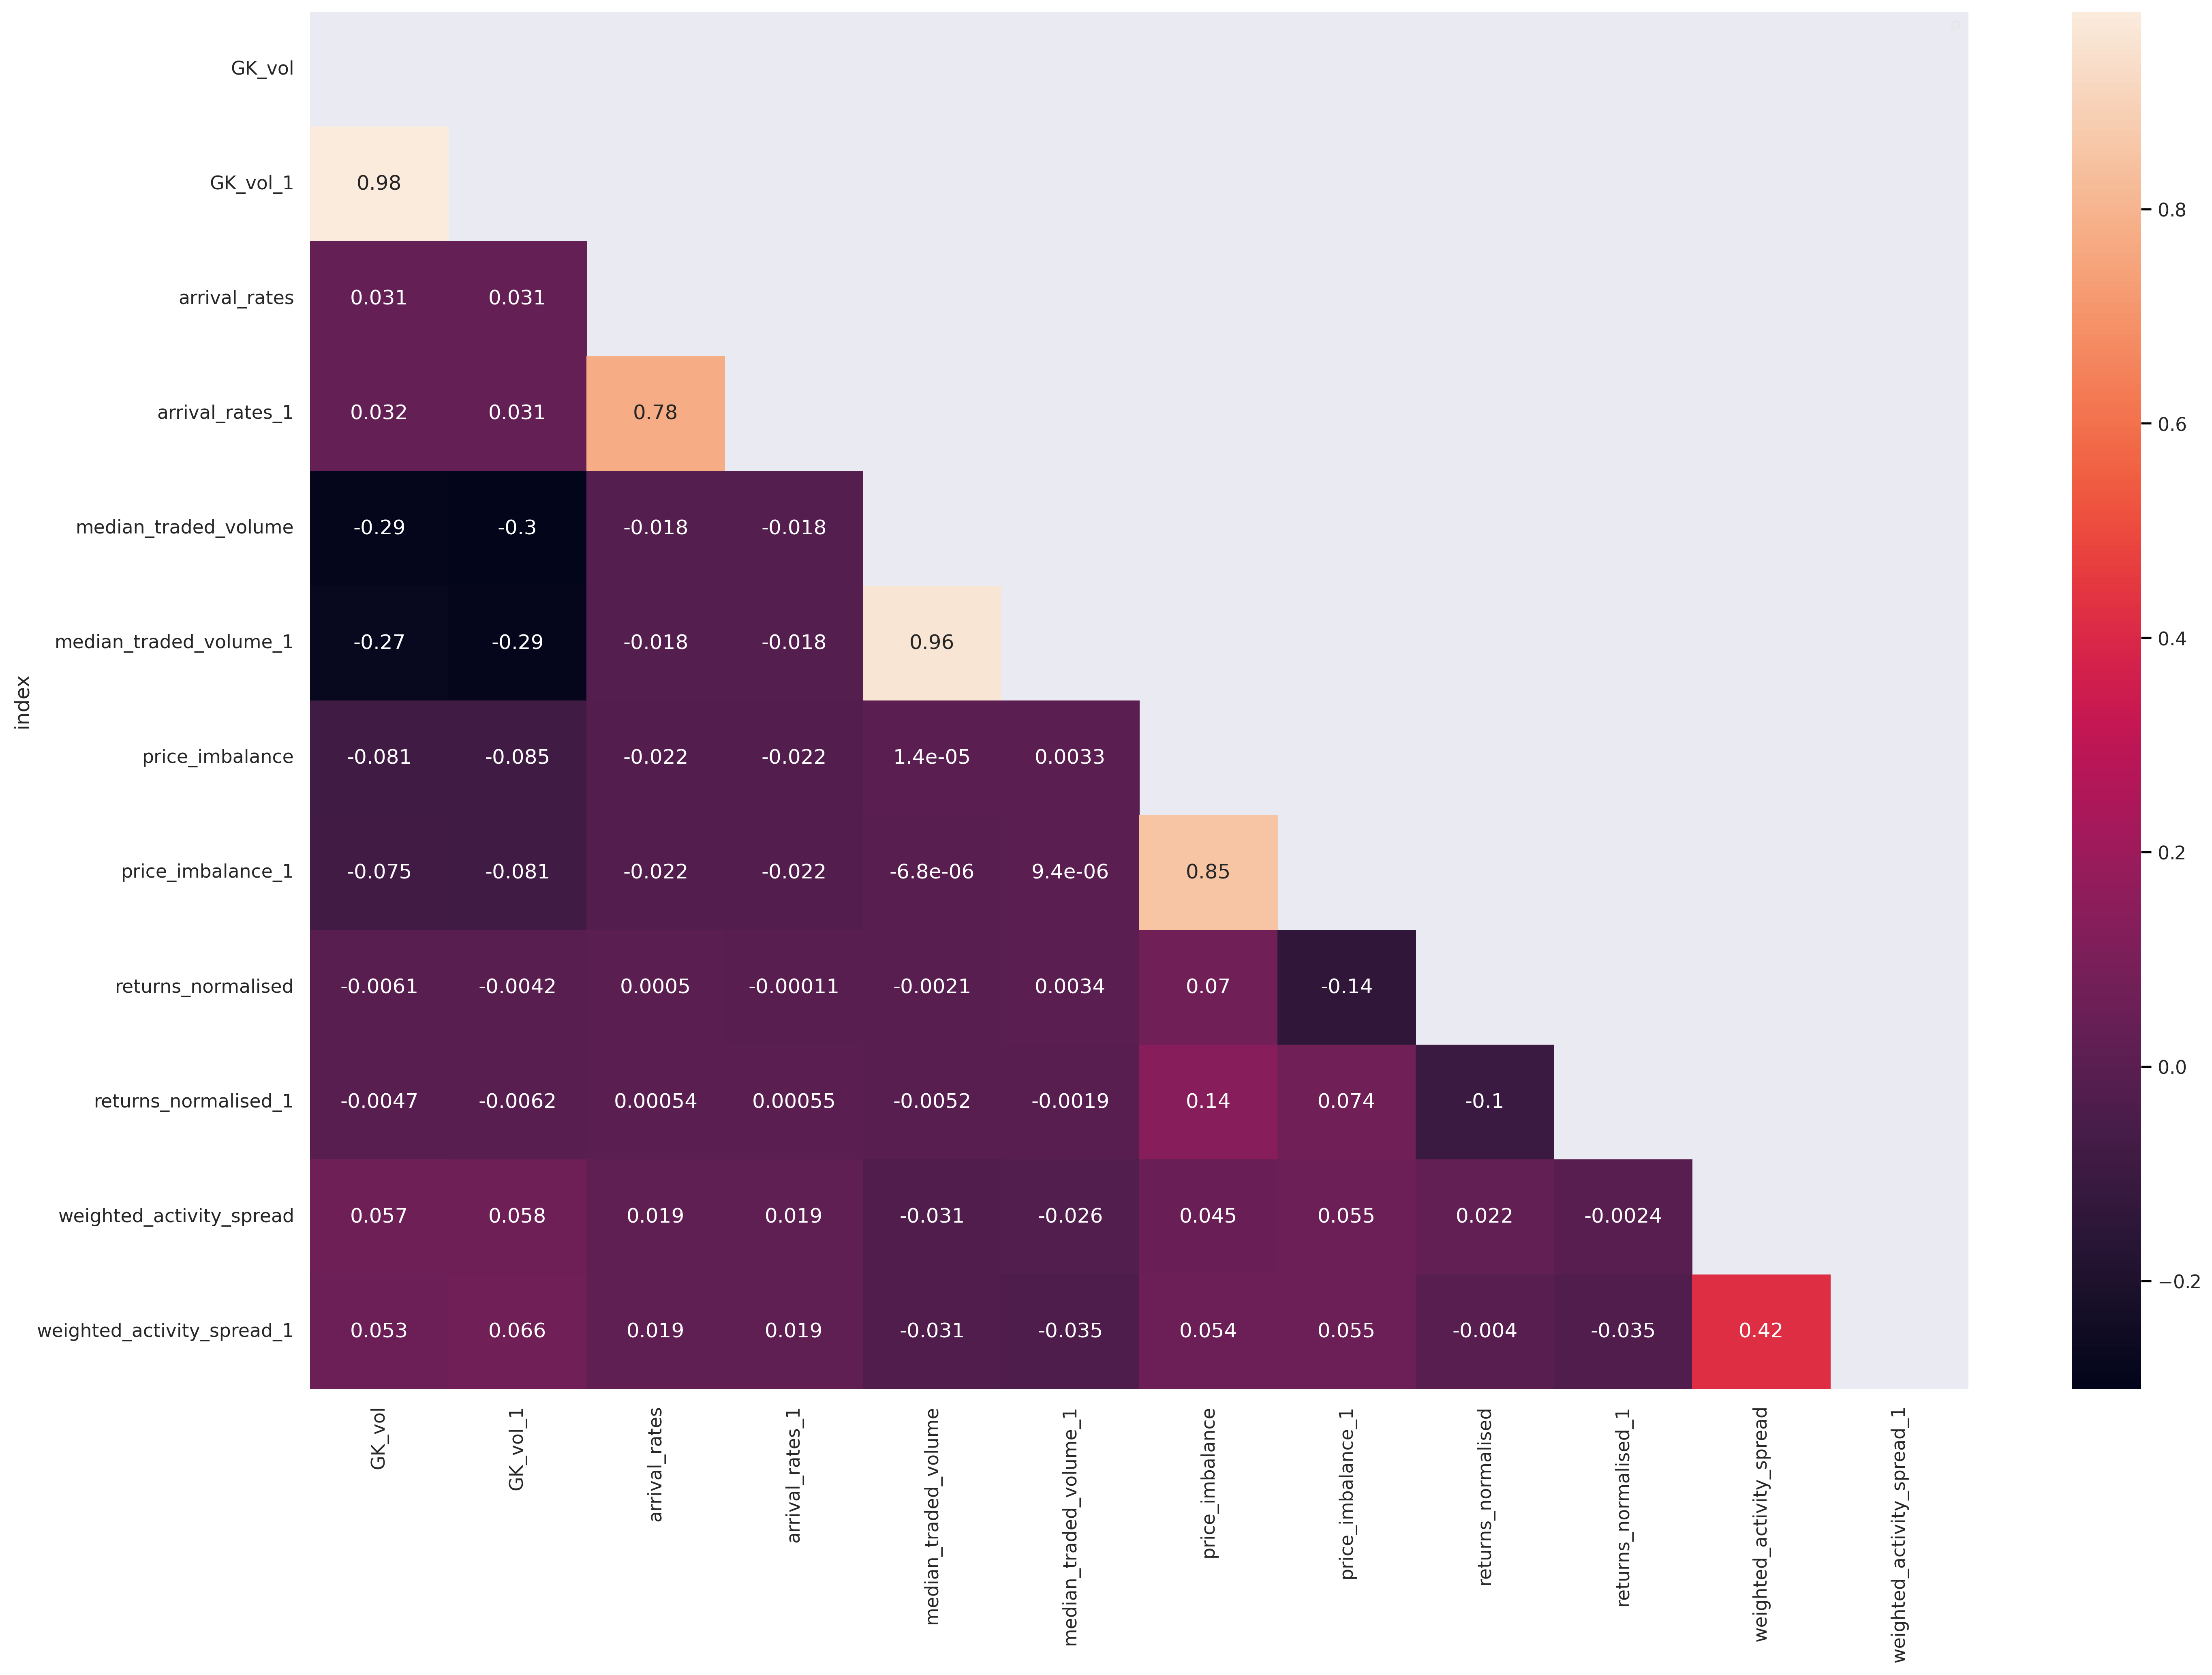

In [18]:
svm = sns.heatmap(correl, mask=mask, annot= True)
# # file_name = 'cross_correlation_two.png'
# # plt.savefig(os.path.join(figures_destination,file_name))
plt.legend()
# plt.show()

In [20]:
labels_list = list(means.columns.values)

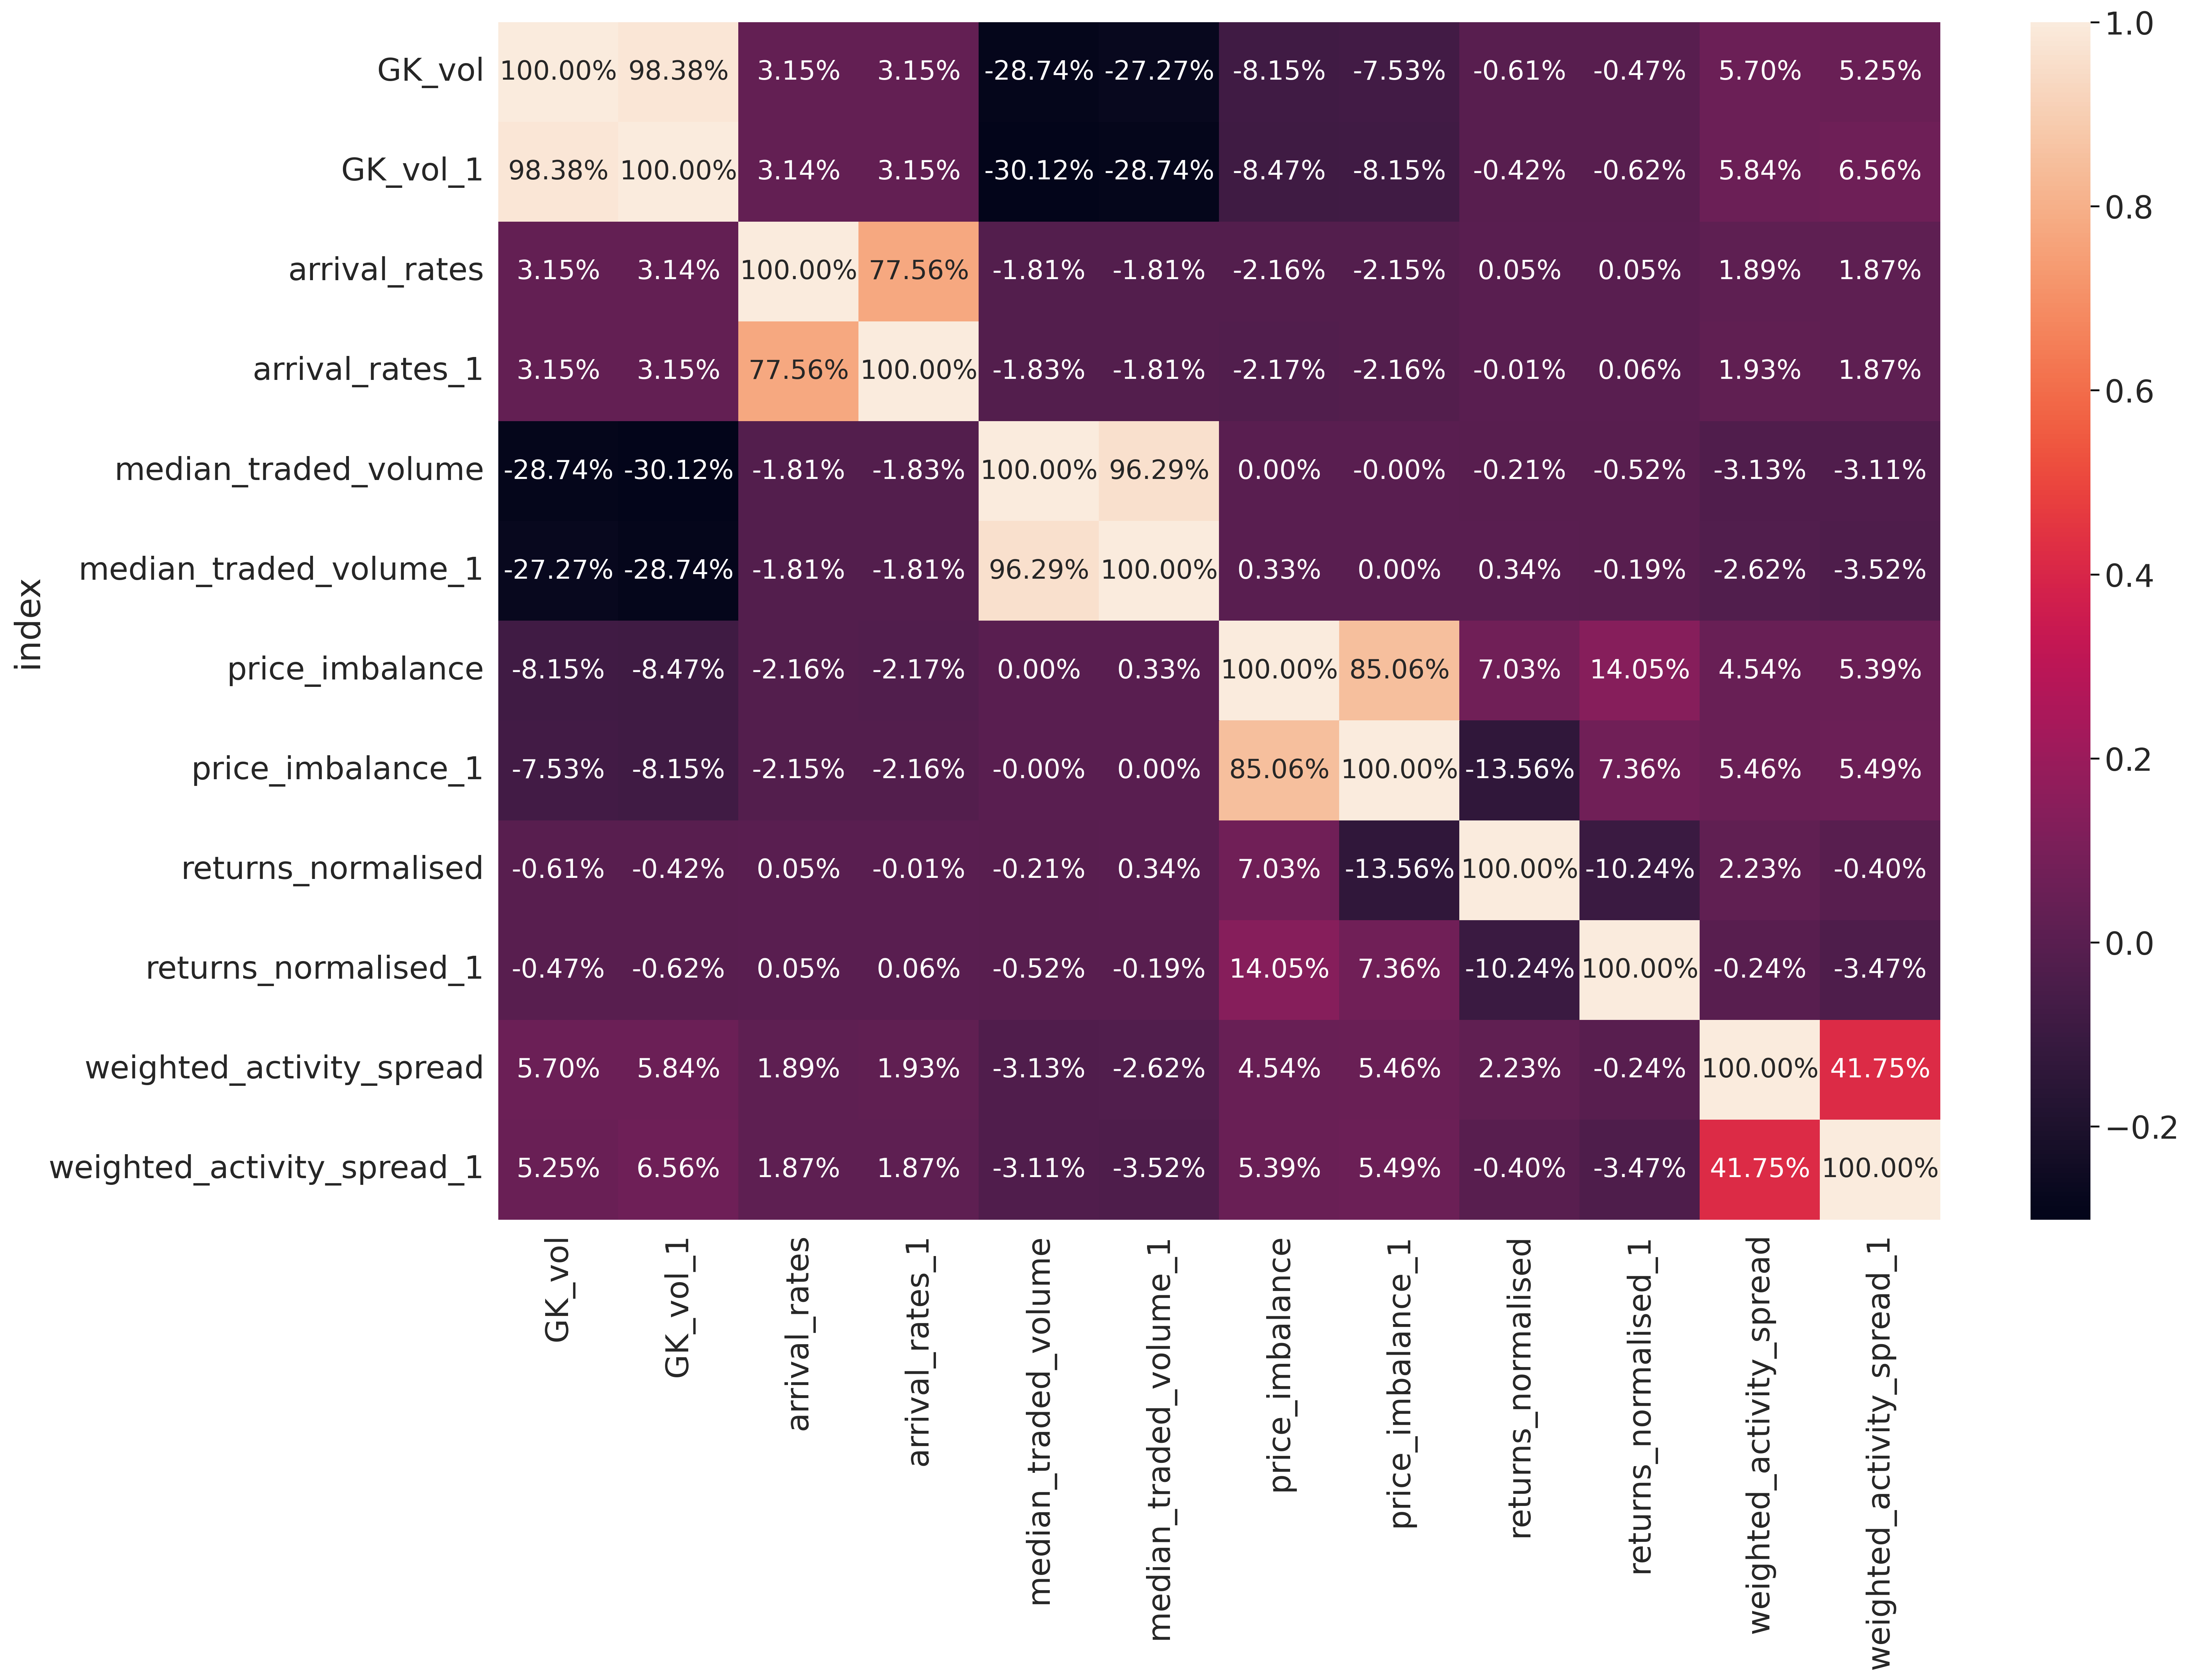

In [24]:
import matplotlib.cm
sns.set(font_scale=1.95)
cmap = matplotlib.cm.get_cmap('Reds')
# , labels = labels_list
cmap = sns.diverging_palette(h_neg=210, h_pos=350, s=5, l=30, as_cmap=True)
_=sns.heatmap(correl,
        xticklabels=labels_list,
        yticklabels=labels_list, annot= True, annot_kws={"size": 18}, fmt=".2%")
file_name = 'RX1'+'_cross_correlation_nov_12.png'
plt.savefig(os.path.join(figures_destination,file_name))

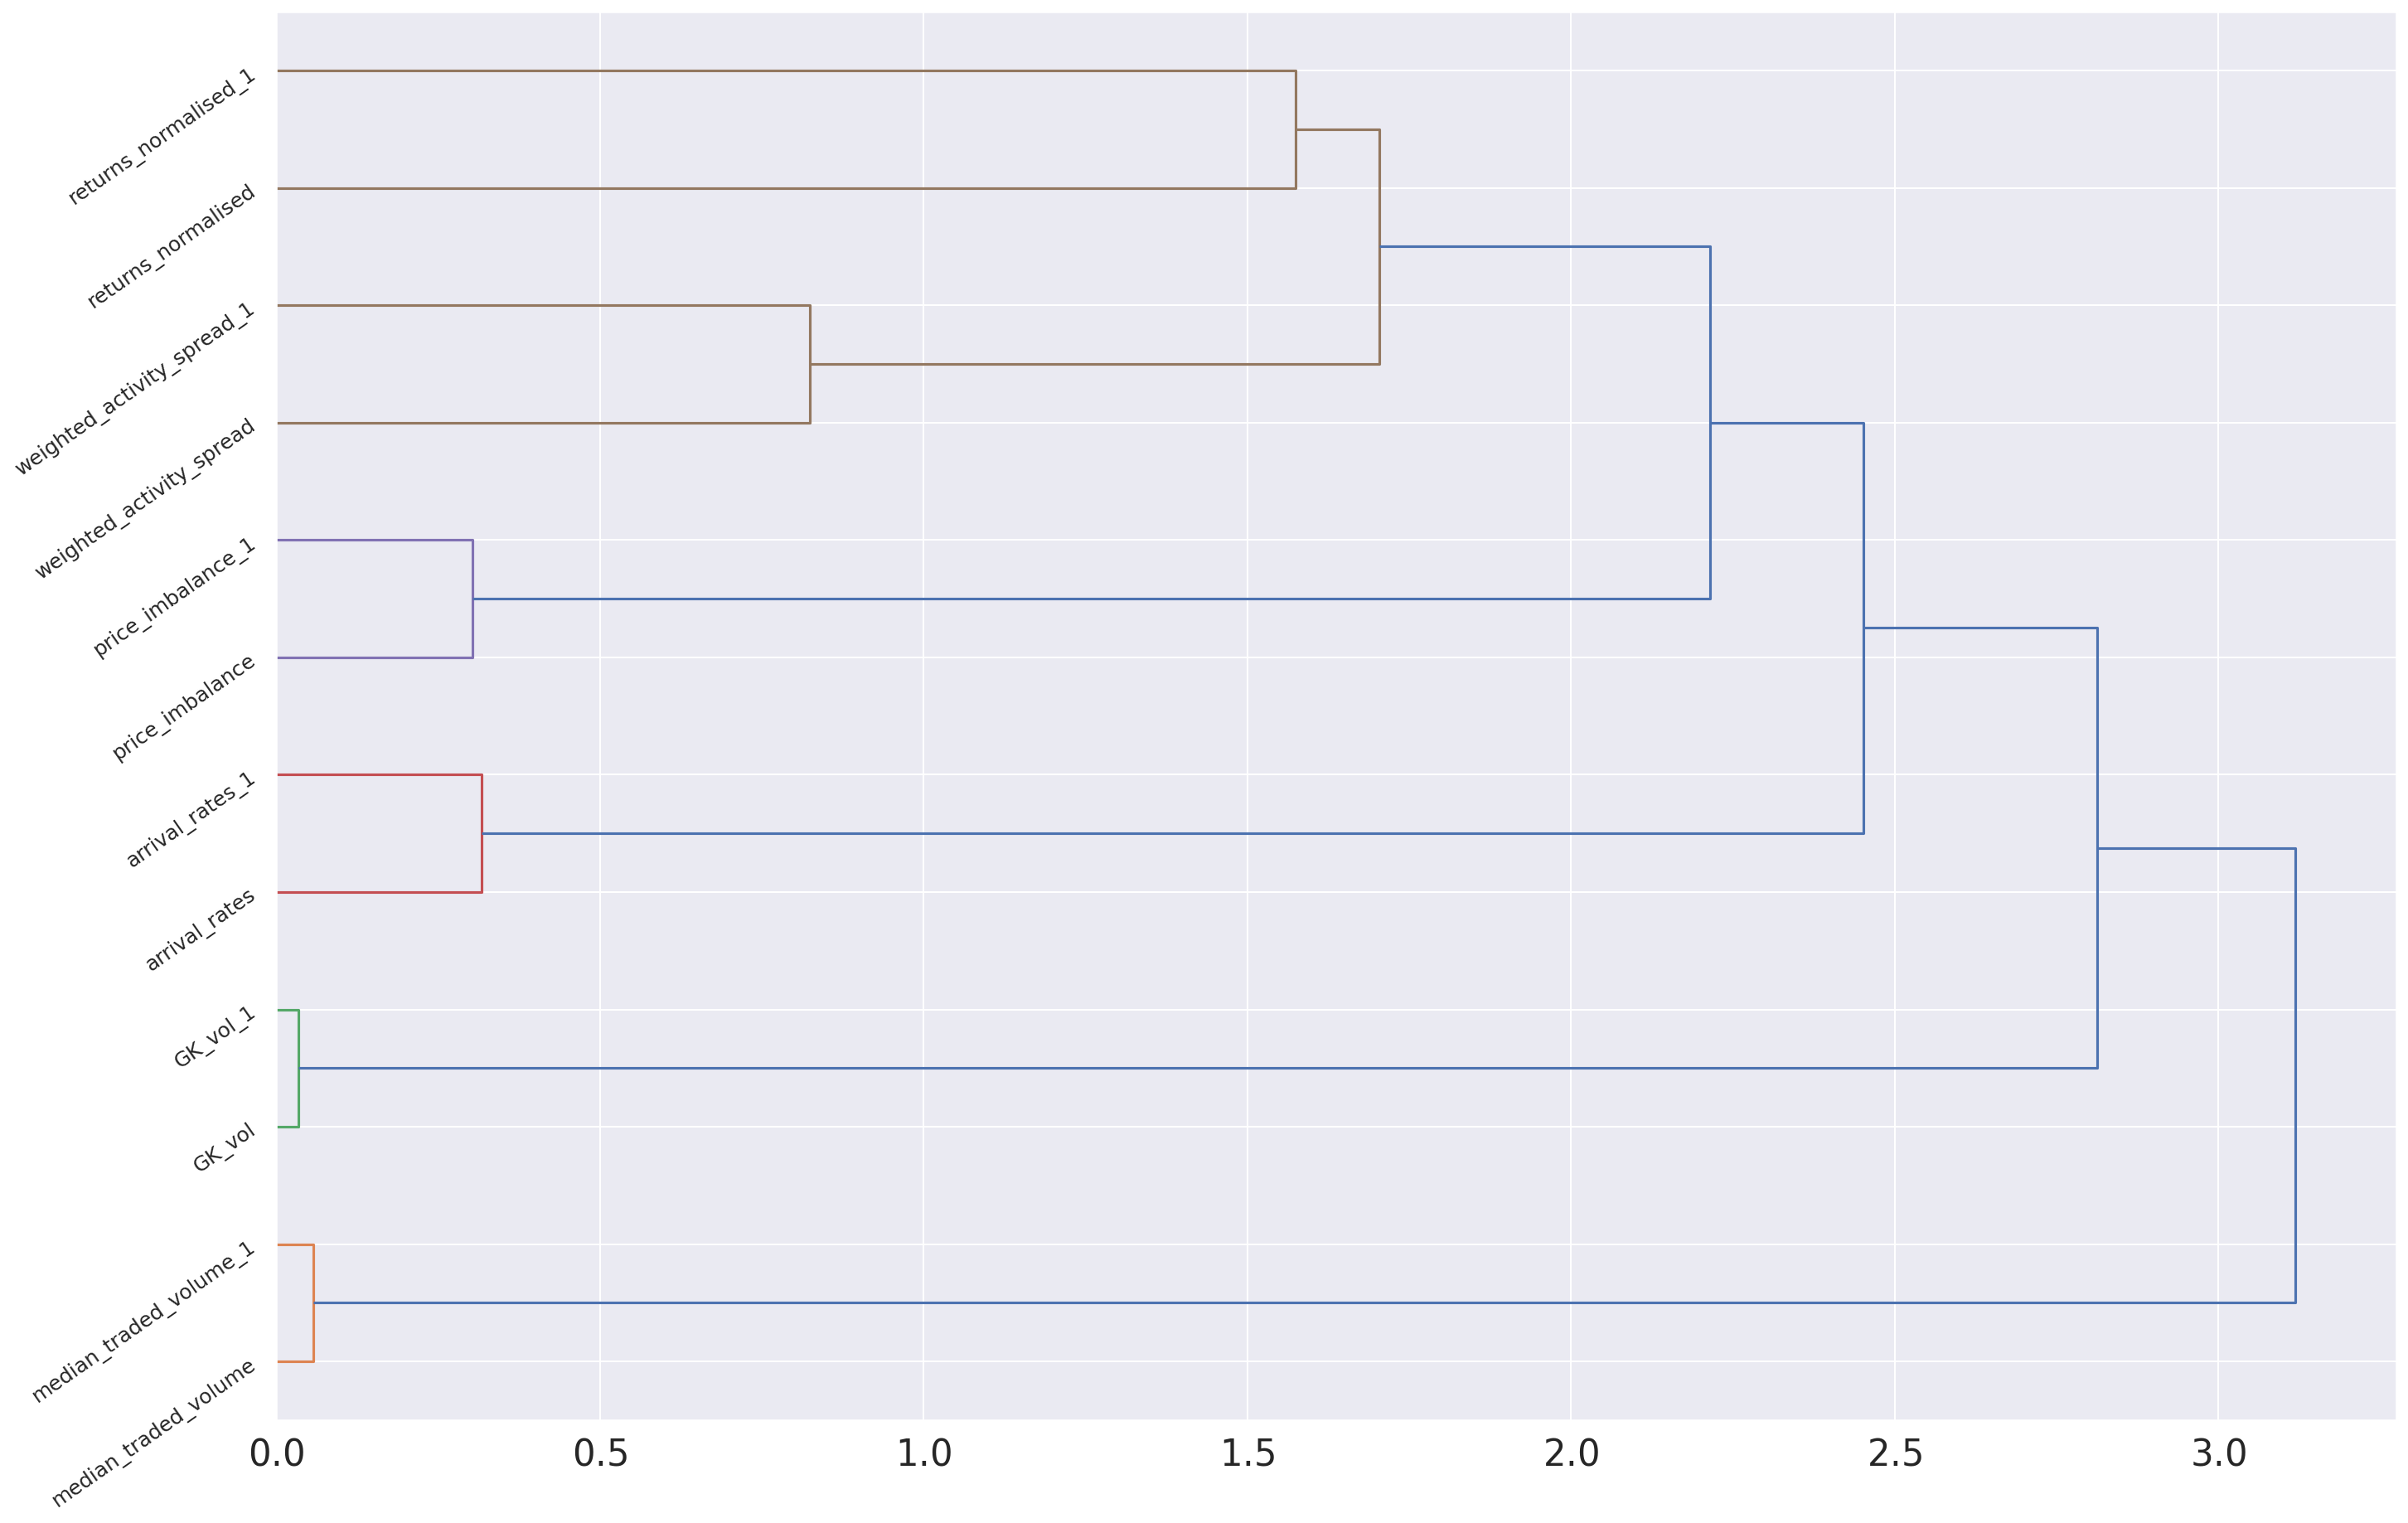

In [121]:
import scipy.cluster.hierarchy as shc
clusters = shc.linkage(correl, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(Z=clusters, orientation='right', 
           leaf_rotation=35 , labels = correl.index, distance_sort='descending');
# dendrogram(Z,  

plt.show()

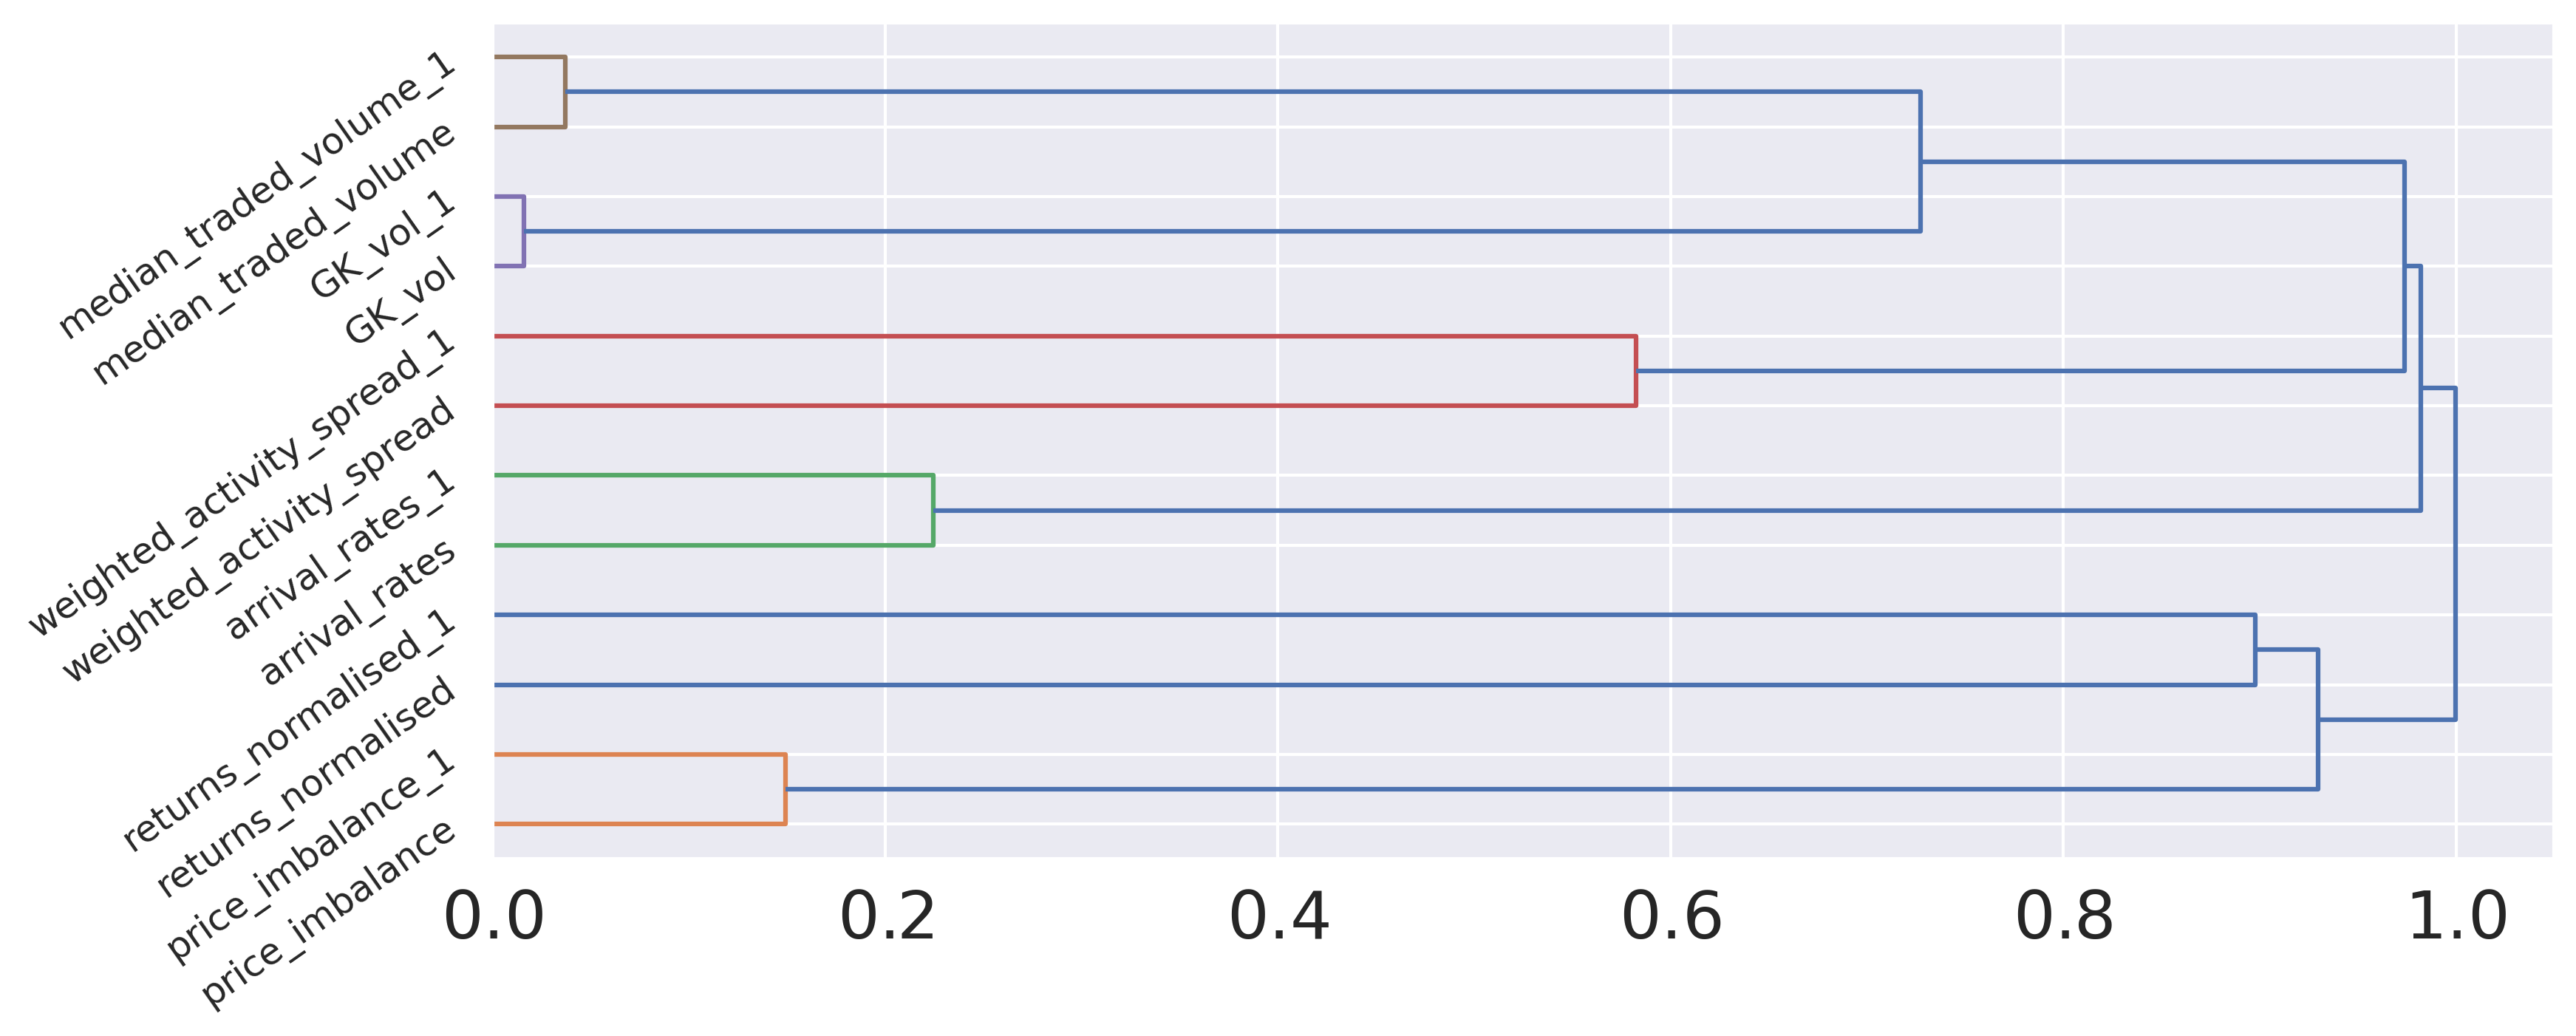

In [26]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

plt.figure(figsize=(12,5))
dissimilarity = 1 - abs(correl)
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z,  orientation='right', 
           leaf_rotation=35 , labels = correl.index, distance_sort='descending');

file_name = 'RX1'+'_dendro_dissimilarity.png'
plt.savefig(os.path.join(figures_destination,file_name))

##### len(correl.columns)

In [27]:
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
selected_data =correl
clustering_model = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
clustering_model.fit(correl)
clustering_model.labels_

array([2, 2, 1, 1, 3, 3, 4, 4, 0, 0, 0, 0])

In [28]:
selected_data.head(10)

,GK_vol,GK_vol_1,arrival_rates,arrival_rates_1,median_traded_volume,median_traded_volume_1,price_imbalance,price_imbalance_1,returns_normalised,returns_normalised_1,weighted_activity_spread,weighted_activity_spread_1
index,,,,,,,,,,,,
GK_vol,1.000000,0.983797,0.031468,0.031537,-0.287425,-0.272732,-0.081491,-0.075326,-0.006148,-0.004659,0.057002,0.052502
GK_vol_1,0.983797,1.000000,0.031449,0.031467,-0.301156,-0.287430,-0.084735,-0.081496,-0.004194,-0.006206,0.058352,0.065601
arrival_rates,0.031468,0.031449,1.000000,0.775585,-0.018122,-0.018055,-0.021564,-0.021506,0.000502,0.000545,0.018935,0.018733
arrival_rates_1,0.031537,0.031467,0.775585,1.000000,-0.018318,-0.018123,-0.021658,-0.021566,-0.000110,0.000554,0.019304,0.018696
median_traded_volume,-0.287425,-0.301156,-0.018122,-0.018318,1.000000,0.962903,0.000014,-0.000007,-0.002102,-0.005184,-0.031321,-0.031097
median_traded_volume_1,-0.272732,-0.287430,-0.018055,-0.018123,0.962903,1.000000,0.003283,0.000009,0.003449,-0.001949,-0.026224,-0.035188
price_imbalance,-0.081491,-0.084735,-0.021564,-0.021658,0.000014,0.003283,1.000000,0.850602,0.070309,0.140544,0.045441,0.053948
price_imbalance_1,-0.075326,-0.081496,-0.021506,-0.021566,-0.000007,0.000009,0.850602,1.000000,-0.135555,0.073613,0.054624,0.054860
returns_normalised,-0.006148,-0.004194,0.000502,-0.000110,-0.002102,0.003449,0.070309,-0.135555,1.000000,-0.102358,0.022289,-0.004029


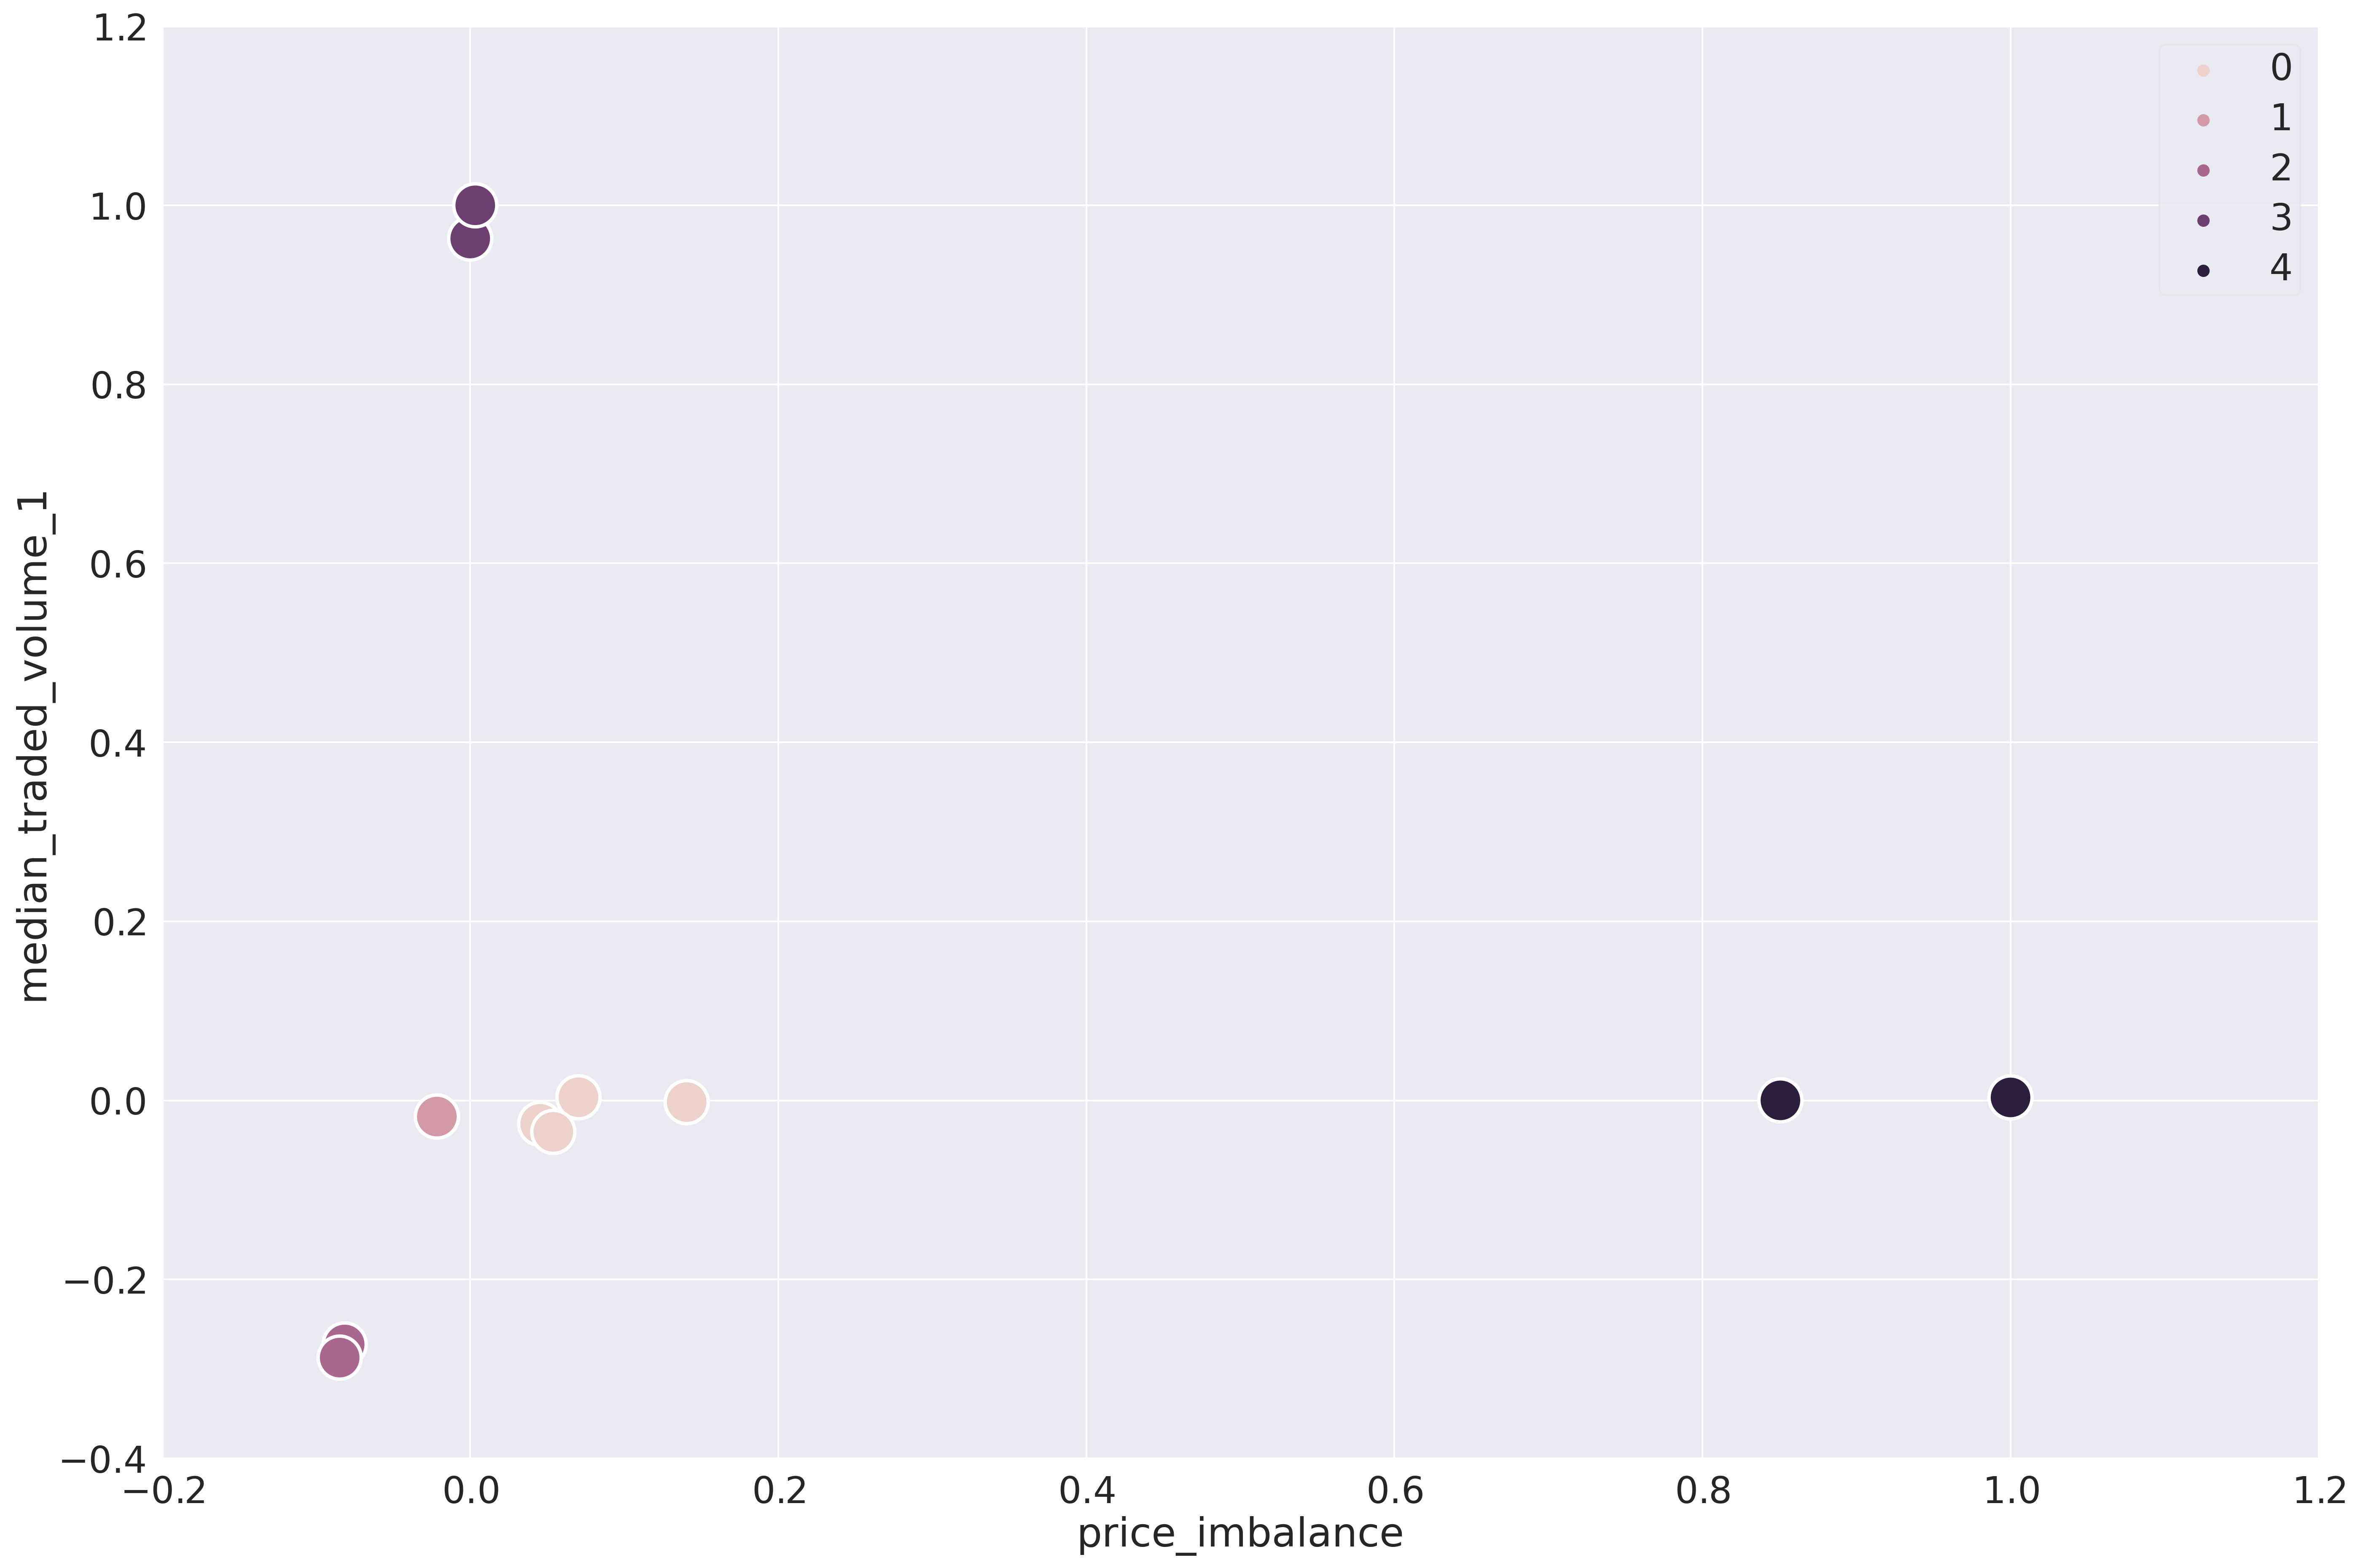

In [29]:
data_labels = clustering_model.labels_
sns.set(font_scale=1.9)
_= sns.scatterplot(x='price_imbalance', 
                y='median_traded_volume_1', 
                data=selected_data, 
                hue=data_labels, s= 600)

file_name = 'RX1'+'anglomerative_cross_correlation_nov_12.png'
plt.savefig(os.path.join(figures_destination,file_name))

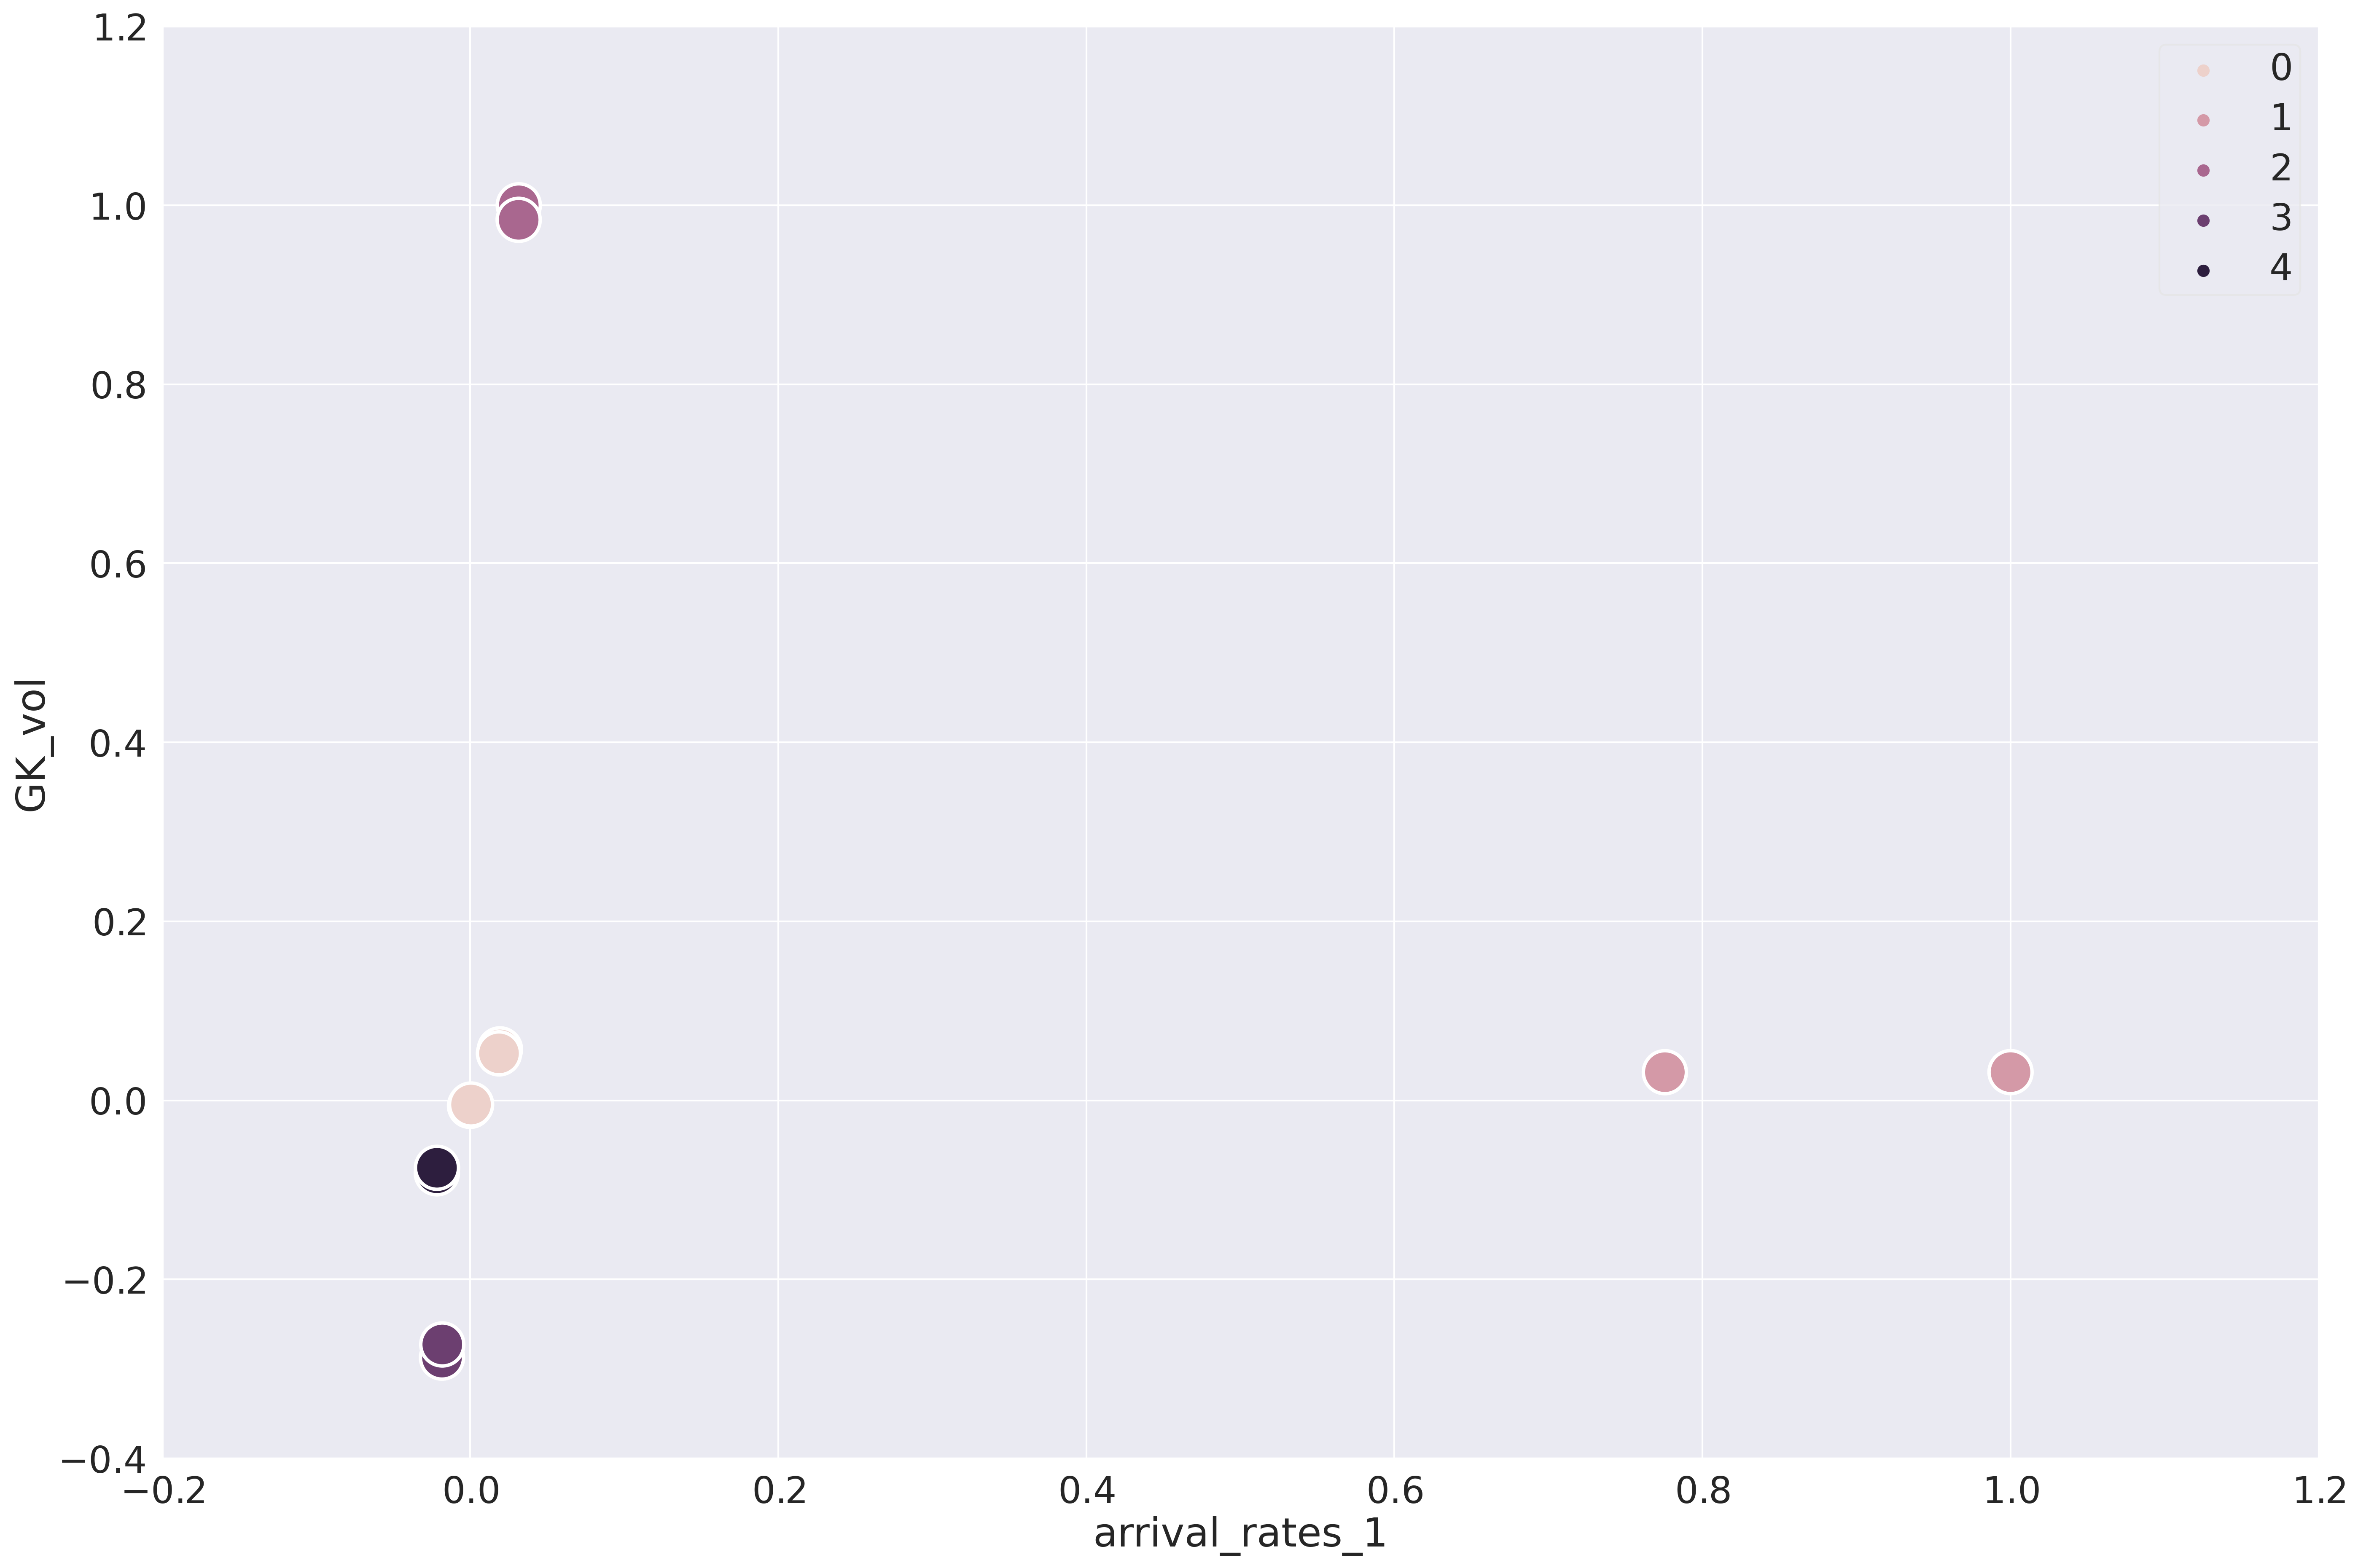

In [30]:
data_labels = clustering_model.labels_
sns.set(font_scale=1.9)
_= sns.scatterplot(x='arrival_rates_1', 
                y='GK_vol', 
                data=selected_data, 
                hue=data_labels, s= 600)

The data points in the bottom right (label: 4, purple data points) belong low median traded volume but high price imbalance. These are environments that things can get messy.